## Initialization

In [ ]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))
import torch
from kar_hnn import KARHNN
from data import get_dataset

## Help Functions

In [2]:
# print squared loss at specific steps for comparison with HNN
print_every = 200
def print_results(results, print_every=200):
    for step in range(0, len(results["train_loss"]), print_every):
        print(
            "step {}, train_loss {:.4e}, test_loss {:.4e}".format(
                step,
                results["train_loss"][step],
                results["test_loss"][step],
            )
        )


def print_best(results):
    curr_min = 0

    for step in range(0, len(results["train_loss"])):
        if results["test_loss"][step] < results["test_loss"][curr_min]:
            curr_min = step
    print(
        "best test loss at step {}, train_loss {:.4e}, test_loss {:.4e}".format(
            curr_min,
            results["train_loss"][curr_min],
            results["test_loss"][curr_min],
        )
    )

## Create Dataset

In [3]:
# create dataset
THIS_DIR = os.path.dirname(os.path.abspath(os.path.join(".")))
data = get_dataset("2body", THIS_DIR, verbose=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.tensor(data["coords"], requires_grad=True, dtype=torch.float32).to(device)
test_x = torch.tensor(data["test_coords"], requires_grad=True, dtype=torch.float32).to(
    device
)
dxdt = torch.Tensor(data["dcoords"]).to(device)
test_dxdt = torch.Tensor(data["test_dcoords"]).to(device)

# dataset['train_input'], dataset['train_label'],dataset['test_input'], dataset['test_label']
dataset = {
    "train_input": x,
    "train_label": dxdt,
    "test_input": test_x,
    "test_label": test_dxdt,
}

Successfully loaded data from /Users/ZongyuWu/hamiltonian-nn/2body-orbits-dataset.pkl


In [4]:
dataset["train_input"].shape, dataset["train_label"].shape

(torch.Size([40000, 8]), torch.Size([40000, 8]))

## Model Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# initialize KAN with G=3
model = KARHNN(
    input_dim=2 * 4, width=[2 * 4, 10, 10, 2], grid=3, k=3, seed=42, device=device
)
results = model.fit(
    dataset, opt="LBFGS", steps=4000, log=1, batch=100
)
print_results(results, 10)
print_best(results)

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-07 | test_loss: 3.50e-07 | reg: 2.74e+01 | : 100%|█| 4000/4000 [07:19<00:00,  9.

saving model version 0.1
step 0, train_loss 2.3964e-03, test_loss 2.8068e-03
step 10, train_loss 5.8142e-05, test_loss 2.2560e-04
step 20, train_loss 7.5654e-05, test_loss 1.2315e-04
step 30, train_loss 1.8850e-05, test_loss 3.9416e-05
step 40, train_loss 1.8310e-05, test_loss 4.0689e-05
step 50, train_loss 1.1809e-05, test_loss 2.9738e-05
step 60, train_loss 8.6727e-06, test_loss 1.9276e-05
step 70, train_loss 1.0234e-05, test_loss 2.3696e-05
step 80, train_loss 6.0580e-06, test_loss 1.6533e-05
step 90, train_loss 4.8376e-06, test_loss 1.3916e-05
step 100, train_loss 4.2437e-06, test_loss 1.6646e-05
step 110, train_loss 6.5314e-06, test_loss 1.2164e-05
step 120, train_loss 9.0053e-06, test_loss 8.3268e-06
step 130, train_loss 6.4727e-06, test_loss 8.4697e-06
step 140, train_loss 5.6967e-06, test_loss 9.4583e-06
step 150, train_loss 6.4464e-06, test_loss 1.4201e-05
step 160, train_loss 4.1740e-06, test_loss 9.0034e-06
step 170, train_loss 3.8674e-06, test_loss 1.6262e-05
step 180, trai

[tensor([2.3893, 2.2598, 3.3000, 3.2758, 0.6384, 0.6417, 0.7330, 0.7289],
       grad_fn=<MeanBackward1>), tensor([0.6972, 0.7899, 0.3712, 0.6233, 1.3594], grad_fn=<MeanBackward1>), tensor([0.6733, 0.3000, 0.6086], grad_fn=<MeanBackward1>), tensor([0.5000, 0.5000], grad_fn=<MeanBackward1>)]


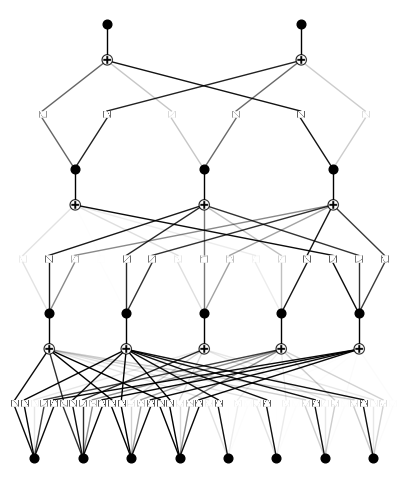

In [17]:
model.attribute()
print(model.node_scores)
model.plot()

saving model version 0.2


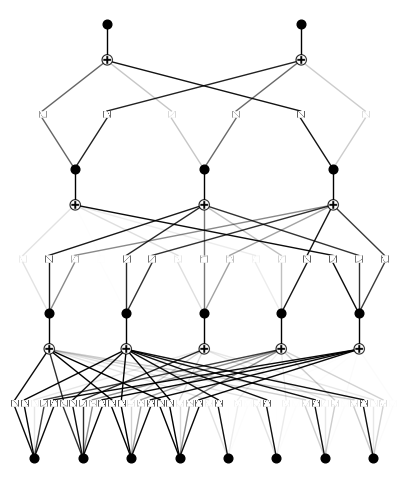

In [18]:
model = model.prune_node(threshold=1e-1)
model.plot()

In [19]:
mode = "auto"  # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0, 0, 0, "x^2")
    model.fix_symbolic(0, 1, 0, "x^2")
    model.fix_symbolic(1, 0, 0, "x")
    model.fix_symbolic(1, 0, 1, "x")
elif mode == "auto":
    # automatic mode
    lib = ["x", "x^2", "x^3", "x^4", "sqrt", "tanh", "sin", "abs", '1/x']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9994572997093201, c=2
fixing (0,0,1) with sin, r2=0.9982730746269226, c=2
fixing (0,0,2) with sin, r2=0.9991258978843689, c=2
fixing (0,0,3) with 1/x, r2=0.9964266419410706, c=2
fixing (0,0,4) with sin, r2=0.9954060316085815, c=2
fixing (0,1,0) with x, r2=0.9212232232093811, c=1
fixing (0,1,1) with x, r2=0.9891531467437744, c=1
fixing (0,1,2) with sin, r2=0.9994405508041382, c=2
fixing (0,1,3) with x, r2=0.702996551990509, c=1
fixing (0,1,4) with sin, r2=0.9865723848342896, c=2
fixing (0,2,0) with sin, r2=0.9997674822807312, c=2
fixing (0,2,1) with sin, r2=0.9998992085456848, c=2
fixing (0,2,2) with x, r2=0.3364689350128174, c=1
fixing (0,2,3) with x, r2=0.0006896699778735638, c=1
fixing (0,2,4) with sin, r2=0.9925537705421448, c=2
fixing (0,3,0) with x^2, r2=0.9984642863273621, c=2
fixing (0,3,1) with sin, r2=0.999426543712616, c=2
fixing (0,3,2) with x^2, r2=0.9780006408691406, c=2
fixing (0,3,3) with x, r2=0.30196860432624817, c=1
fixing (0,3,4) with si

In [20]:
from kan.utils import ex_round

[ex_round(y, 4) for y in model.symbolic_formula()[0]]

KeyboardInterrupt: 

![hnn](./hnn.png)
![baseline](./baseline.png)
